In [1]:
%cd ../../

c:\Users\vince\Documents\school\Unief-6\6-bap


In [47]:
import os
import pandas as pd
import re
import datetime

data = pd.DataFrame(columns=['Name', 'Architecture', 'Size (#B)', "Score", "RunTime", "RAG_Window", "RAG_Type"])

runDir = './scores/30-04-2024-0'
i = 1
for subdir, _ , scoreFiles in os.walk(runDir):
    if len(scoreFiles) == 0:
        continue
    name = subdir.split('\\')[-1]
    averageScore = 0
    averageTime = 0.0
    ragWindow = 0
    size = 0
    architecture = ''
    ragType = 'None'
    if 'scores' in name:
        continue
    if "RAG" in name:
        ragWindow = 1024 * int(re.findall(r"(?<=RAG)\d", name)[0])
    if "page" in name:
        ragType = 'Page' + str(ragWindow // 1024) + 'K'
    elif 'paragraph' in name:
        ragType = 'Paragraph' + str(ragWindow // 1024) + 'K'
    if "mistral" in name.lower():  
        size = 7
        architecture = "Mistral"
    elif "mixtral" in name.lower():
        size = 8*7
        architecture = "Mixtral"
    elif "llama-3" in name.lower():
        size = 70
        architecture = "LLama"
    for scoreFile in scoreFiles:
        with open(subdir + "/" + scoreFile, 'r') as file:
            for line in file.readlines():
                if "overal Score:" in line:
                    scores = re.findall(r"\d+", line)
                    averageScore += (1.0* int(scores[0]) / int(scores[1]))/len(scoreFiles)
                    continue
                if "Time to completion:" in line:
                    hours, minutes, seconds = map(float, line.split(' ')[-1].split(':'))
                    time = datetime.timedelta(hours=hours, minutes=minutes, seconds=seconds)
                    averageTime += time.total_seconds()/len(scoreFiles)
    data.loc[i] = [name, architecture,size, averageScore, averageTime, ragWindow, ragType]
    i += 1

data.sort_values('Score', inplace=True, ascending=False)
# data.to_csv(runDir +  '/analysis.csv')
data['deltaRAG_score'] = 0
for index, row in data.iterrows():
    architecture = row['Architecture']
    score = row['Score']
    referenceScore = data[(data['Architecture'] == architecture) & (data['RAG_Window'] == 0)].iloc[0]['Score']
    data.at[index, 'deltaRAG_score']= score - referenceScore
        
    
print(data)

                           Name Architecture  Size (#B)     Score     RunTime  \
9        mixtral-8x7B-RAG2kpage      Mixtral         56  0.811594  267.773894   
1                   llama-3-70B        LLama         70  0.739130  139.857152   
11       mixtral-8x7B-RAG4kpage      Mixtral         56  0.739130  199.373206   
13                  mixtral8x7B      Mixtral         56  0.739130  285.664859   
10  mixtral-8x7B-RAG2kparagraph      Mixtral         56  0.695652  273.142689   
12  mixtral-8x7B-RAG4kparagraph      Mixtral         56  0.623188  283.274161   
3     mistral-7B-RAG2kparagraph      Mistral          7  0.608696   65.171371   
5     mistral-7B-RAG4kparagraph      Mistral          7  0.536232   68.062149   
2          mistral-7B-RAG2kpage      Mistral          7  0.521739   52.697529   
4          mistral-7B-RAG4kpage      Mistral          7  0.507246   69.872846   
6                     mistral7B      Mistral          7  0.507246   45.246575   
7                  mistral7B

KeyError: 'Architecty'

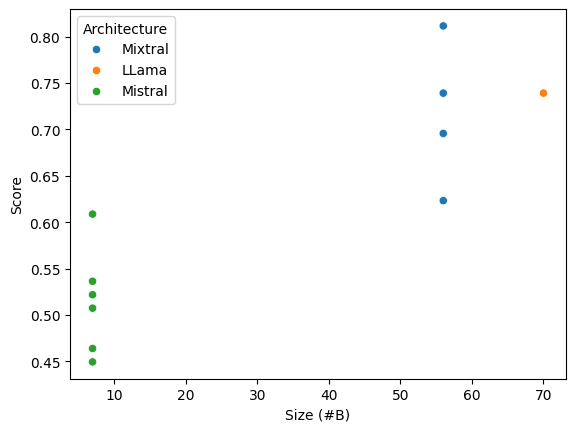

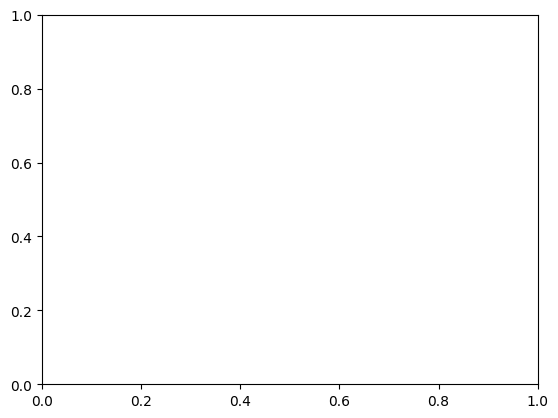

In [54]:
import matplotlib.pyplot as plt
import matplotlib.lines as lines
import numpy as np
import seaborn as sns

fig1, ax1 = plt.subplots()
sns.scatterplot(x='Size (#B)', y='Score', hue='Architecture', data=data, ax=ax1)
fig2, ax2 = plt.subplots()
dfRAGNoLLama = data[(data['RAG_Type'] != 'None') & (data['Architecture'] != 'LLama')]
ind = np.arange(len(dfRAGNoLLama['Architecture'].unique()))
for i, ragType in enumerate(dfRAGNoLLama['RAG_Type'].unique()):
    values = [dfRAGNoLLama[dfRAGNoLLama[dfRAGNoLLama['Architecture'] == architecture & dfRAGNoLLama['RAG_Type'] == ragType]] for architecture in dfRAGNoLLama['Architecty'].unique()]
    ax2.bar(ind + i*50, values, 50, label=ragType)
    
    

# ax2.add_line(lines.Line2D([0, 4096], [0, 0]))
plt.show()